## Initial steps:

1.   Copy this notebook to your google Colab account (*File --> Save a Copy in Drive*)
2.   Go to your drive and open the copied file, located in your *Colab Notebooks* folder

##Working with Collab Notebooks:

1.   Click inside a cell with code and press SHIFT+ENTER (or click "PLAY" button) to execute it.
2.   Re-executing a cell will reset it (any input will be lost).
3.   Execute cells TOP TO BOTTOM.
4.  Use TAB for [code autocompletion and function parameters hint](https://colab.research.google.com/notebooks/basic_features_overview.ipynb#scrollTo=d4L9TOP9QSHn)
5. Notebooks are saved to your Google Drive (make sure to click on "COPY TO DRIVE" when opening a notebook shared with you).
6. Mount your Google Drive to have a direct access from a notebook to the files stored in the drive (this includes Team Drives).
7. If using Colab's virtual storage only, all the uploaded/stored files will get deleted when a runtime is recycled.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
google_drive_dir = "/content/gdrive/My Drive/EASY-ChargeCollection/"
!mkdir "$google_drive_dir"

mkdir: cannot create directory ‘/content/gdrive/My Drive/EASY-ChargeCollection/’: File exists


In [ ]:
# Download Data
easydata_zip = google_drive_dir+"EasyDATA.zip"
!wget https://www.dropbox.com/sh/7o5xy3bad99vmwi/AACTjc49mADsd7Jni0q31mXma?dl=1 -O "$easydata_zip"
%cd "$google_drive_dir"
!unzip EasyDATA.zip


--2021-07-19 09:47:23--  https://www.dropbox.com/sh/7o5xy3bad99vmwi/AACTjc49mADsd7Jni0q31mXma?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/7o5xy3bad99vmwi/AACTjc49mADsd7Jni0q31mXma [following]
--2021-07-19 09:47:23--  https://www.dropbox.com/sh/dl/7o5xy3bad99vmwi/AACTjc49mADsd7Jni0q31mXma
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc403c2fe1b5c40c4698f2688c8.dl.dropboxusercontent.com/zip_download_get/A18uQpvN5XxPnsZRu5Mkk54mZUOQjagNgxAoFVfhvBgpH4x49Bb6DDAAIywQ9SM0VdvCBxsxDzPW1_xSGQXiCvvK5ZaACE1m83StzNwK4V4xXw?dl=1# [following]
--2021-07-19 09:47:24--  https://ucc403c2fe1b5c40c4698f2688c8.dl.dropboxusercontent.com/zip_download_get/A18uQpvN5XxPnsZRu5Mkk54mZUOQjagNgxAoFVfhvBgpH4x49Bb6DDAAIywQ9SM0VdvCBxsxDzPW1

In [ ]:
!echo "$easydata_zip"

/content/gdrive/My Drive/EASY/EasyDATA.zip


# Load Libraries

In [ ]:
import os
import sys

from   scipy.stats import norm as gaus
from   scipy import optimize
import h5py
import time
import math
from optparse import OptionParser
from numpy import *

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.patches as patches
import numpy as np

from scipy.stats import norm

# Functions

In [ ]:
#########################################
# Define Landau (Moyal) and error function
#########################################

def fLandau(p, x):
    """ Approximate the landau distribution with the Moyal
        distribution
        
        Parameters:
            p[0] = normalization
            p[1] = mode
            p[2] = width
    """
    L = (x-p[1])/p[2]
    r = p[0]*exp(-0.5*(L+exp(-L)))/2.506628274631001 #math.sqrt(2.0*math.pi)
    return r

def fitLandau(p, x, y):
    """ This is the 'error' function we use for
        the fit.
    """
    return fLandau(p, x) - y

########################################
# Define Gaussian and error function
########################################

def fgauss(p, x):
    """ This is a gaussion.
        Parameters:
           p[0] = maximum
           p[1] = mean
           p[2] = sigma
    """
    L  = (x-p[1])/p[2]
    L1 = p[0]*exp(-0.5*L*L)/(2.506628274631001*p[2])
    return L1

def fitGauss(p, x, y):
    """ The error function
    """
    return fgauss(p, x) - y

In [ ]:
#########################################
# Implements the GLib GTimer
#########################################
class GTimer(object):
    """ Implements the GLib GTimer
    """
    def __init__(self):
        self._start = 0
        self._end = 0
        self._running = False
        
    def start(self):
        self._start = time.time()
        
    def __call__(self):
        if self._running:
            return time.time() - self._start
        
        else:
            return 0.0
        
    def start(self):
        self._start = time.time()
        self._running = True
        
    def stop(self):
        self._running = False
        
    def reset(self):
        if self._running:
            self._start = time.time()

# Process Event Class

In [ ]:
########################################
#    Process the event 
# Get signal, common noise, noise and S/N
######################################### 
def process_event(ievt, S, nchan, pedestal, noise):
    
    # signal without pedestals
    ss = single(S[ievt,:]) - pedestal
    
    # compute ans subtract common mode
    cm = 0
    cmsig = 0
    ssnew = zeros(nchan)
    chpas = 0
    cmnew = 0
    cmsignew = 0

    # First iteration to get mean and std
    
    cm= mean(ss[0:128])
    cmsig= std(ss[0:128])
 
    # Remove chanells with a charge larger than 3*std 
    
    chpas=0
    for ch in range(0, nchan):
        if ss[ch]<(cm+(5*cmsig)):
            ssnew[chpas]= ss[+ch]
            chpas = chpas+1

   # Second iteration to get mean and std
    cmnew = mean(ssnew[0:chpas])
    cmsignew= std(ssnew[0:chpas])

    ss[0:128] -= cmnew 

    cm =cmnew
    sn = ss/noise
   
    return ss, sn, cm


# Check Data

In [ ]:
data_files = [os.path.join(google_drive_dir,f) for f in os.listdir(google_drive_dir) if os.path.join(google_drive_dir, f).endswith("h5")]
data_list = {i: data_files[i] for i in range(0, len(data_files))}
data_list

{0: '/content/gdrive/My Drive/EASY-ChargeCollection/Diodo-lat130-Pulse-Rec.h5',
 1: '/content/gdrive/My Drive/EASY-ChargeCollection/Diodo-lat131-Pulse-Rec.h5',
 2: '/content/gdrive/My Drive/EASY-ChargeCollection/Diodo-lat129-Pulse-Rec.h5',
 3: '/content/gdrive/My Drive/EASY-ChargeCollection/Diodo-lat129.h5',
 4: '/content/gdrive/My Drive/EASY-ChargeCollection/Diodo-lat129-10V.h5',
 5: '/content/gdrive/My Drive/EASY-ChargeCollection/Diodo-lat129-20V.h5',
 6: '/content/gdrive/My Drive/EASY-ChargeCollection/Diodo-lat129-30V.h5',
 7: '/content/gdrive/My Drive/EASY-ChargeCollection/Diodo-lat129-40V.h5',
 8: '/content/gdrive/My Drive/EASY-ChargeCollection/Diodo-lat129-50V.h5',
 9: '/content/gdrive/My Drive/EASY-ChargeCollection/Diodo-lat129-60V.h5',
 10: '/content/gdrive/My Drive/EASY-ChargeCollection/Diodo-lat129-70V.h5',
 11: '/content/gdrive/My Drive/EASY-ChargeCollection/Diodo-lat129-80V.h5',
 12: '/content/gdrive/My Drive/EASY-ChargeCollection/Diodo-lat129-90V.h5',
 13: '/content/gdrive

## Options

In [ ]:
#################################################
### Select File
#################################################
usedata_file = 11

#################################################
### Signal Processing
#################################################

# Signal/Noise cut
options_sncut = 6.
# Minimum TDC to be considered in the analysis
options_tmin = 0.
# Maximum TDC to be considered in the analysis
options_tmax = 100.

#################################################
### Fit Settings
#################################################

# It will try a gauss fit to the data
option_gauss = False
# It will try a Landau-like fit to the data
options_landau = True

#################################################
### Plot Settings
#################################################

# Minimum ADC for the fit
options_fmin = 100.
# Maximun ADC for the fit
options_fmax = 250.
# Minimum ADC for the plot
options_ADCmin = 0.
# Maximum ADC for the plot
options_ADCmax = 600.
# Binning for ADC plot
options_ADCbin = 6.
# Minimum energy for the fit
options_Emin = 70.
# Maximum energy for the fit
options_Emax = 200.
# Minimum Energy for the plot
options_Eplotmin = 0.
# Maximum Energy for the plot
options_Eplotmax = 300.
# Binning for Energy plot
options_Eplotbin = 3.
# Label for the plots
options_label = "Sr-90"


#################################################
### Calibration (DO NOT MODIFY)
#################################################

# Parameter 0 to convert ADCs to Energy
options_PE0 = -270.13
# Parameter 1 to convert ADCs to Energy
options_PE1 = 160.904
# Parameter 2 to convert ADCs to Energy
options_PE2 = 0.174026
# Parameter 3 to convert ADCs to Energy
options_PE3 = -0.000734166
# Parameter 4 to convert ADCs to Energy
options_PE4 = 0.0000018750



# Run Over Data

In [ ]:
##################################
# Open data files
##################################    

fname = data_list[usedata_file]
print(" FILE    :",fname)


F = h5py.File(fname, 'r')


# Get pedestals and noise
pedestal = F['/header/pedestal']
noise    = F['/header/noise']


# Get the signal array
S = F['/events/signal']

tmin=float(options_tmin)
tmax=float(options_tmax)
sncut = float(options_sncut)


# Convert pedestal and noise to "vectors"
pedestal = pedestal[0,:]
noise    = noise[0,:]
sz       = pedestal.shape

# Get the number of channesl
nchan    = sz[0]

#
# Now process the whole file
#
# Get the events with good timing

T     = F['/events/time']
GT    = nonzero(T[:]>tmin)

# Number of events in file with good time
nevts = GT[0].shape[0]

# Reduce the data sample to those events
print ("Loop on Events. ..................... Nevt=", nevts)

TT = GTimer() # This is to show the number of events processed
TG = GTimer() # This is to profile the process

Ttot = 0.0
#
# This is to keep the cluster energy
#
G = zeros(0)
Graw = zeros(0)
Gcal = zeros(0)  
        

H = zeros(nchan)
SelCl = zeros(nchan)
CLsize = zeros(nchan)

#
# This is to keep the Hip map
#
Hitm = zeros(nchan)

#
# This is to keep the timming of the cluster


TMap=zeros(101)
TCls=zeros(101)

#
# This is to keep the common mode of each event
#
C = 0.


#
# Start the timers and the main loop
#     
TT.start()
TG.start()

nevtot=0.

########################
# Loop over events
########################

#for im , ievt in enumerate(GT[0]):
for  ievt in  range(0,2000):
        
    if T[ievt]<=tmin or T[ievt]>tmax :
        continue
    ic = ievt

    # Process the event
    ss, sn, cm = process_event(ievt, S, nchan, pedestal, noise)
    nevtot= nevtot +1

    
    if TT() > 1.0:
        print (  "Processing .... (event number, total number of events):",ievt, int(nevtot))
        
        TT.reset()
        
    # Append the commpn mode.
    
    C = append(C, cm)


    #
    # find the clusters
    #
    used = [ False for x in range(0, nchan) ]
    channels = nonzero(sn>sncut)
    
    nclus = 0
    EClst = zeros(nchan)
    
    for ch in channels[0]:
        ###############
        # Mask channels
        ###############
        if ch>51. and ch<55.:
            used[ch]= True

        if not used[ch]:
            nclus= nclus +1 
            EClst[nclus] = ss[ch]
            clst = [ch]
            Hitm [ch] = Hitm [ch] + 1
            used[ch] = True
                
            for i in range(ch+1, nchan, 1):
                if sn[i]>sncut and not used[i]:
                    clst.append(i)
                    used[i] = True
                    EClst[nclus] = EClst[nclus] + ss[i]
                    Hitm [i] = Hitm [i] + 1
                else:
                    break

        
            ind=int(T[ievt])
            TMap[ind]=TMap[ind]+EClst[nclus]
            TCls[ind]= TCls[ind]+1
          
            if EClst[nclus]>(sncut*1):
                isz = int(size(clst))
                CLsize[isz] = CLsize[isz] +1
              
                


            SelCl[nclus] = 0
            
                
    H[nclus] = H[nclus]+1

    SelCl[nclus] = 1
    
    
    
    for i in range(1, nclus+1):
        if EClst[i]>(sncut*1.) and SelCl[nclus]>0.:
            G = append(G, EClst[i])
            PE0 = options_PE0
            PE1 = options_PE1
            PE2 = options_PE2
            PE3 = options_PE3
            PE4 = options_PE4
            Elec = PE0 + (PE1*EClst[i]) + (PE2*(EClst[i]**2)) +(PE3*(EClst[i]**3))+(PE4*(EClst[i]**4))
            Elec = Elec * 3.67
            if Elec>0.:
                Elec = Elec/1000
      
            Gcal = append(Gcal, Elec)
          
            
            
      
TT.stop()    
print ("\nTotal time elapsed:                 ", TG())
print ("\nTotal events processed in time:     ", nevtot)

 FILE    : /content/gdrive/My Drive/EASY-ChargeCollection/Diodo-lat129-80V.h5
Loop on Events. ..................... Nevt= 47765
Processing .... (event number, total number of events): 606 607
Processing .... (event number, total number of events): 1231 1231
Processing .... (event number, total number of events): 1836 1836

Total time elapsed:                  3.274527072906494

Total events processed in time:      1999.0


# Produce Plots

### Common Mode and Hitmap

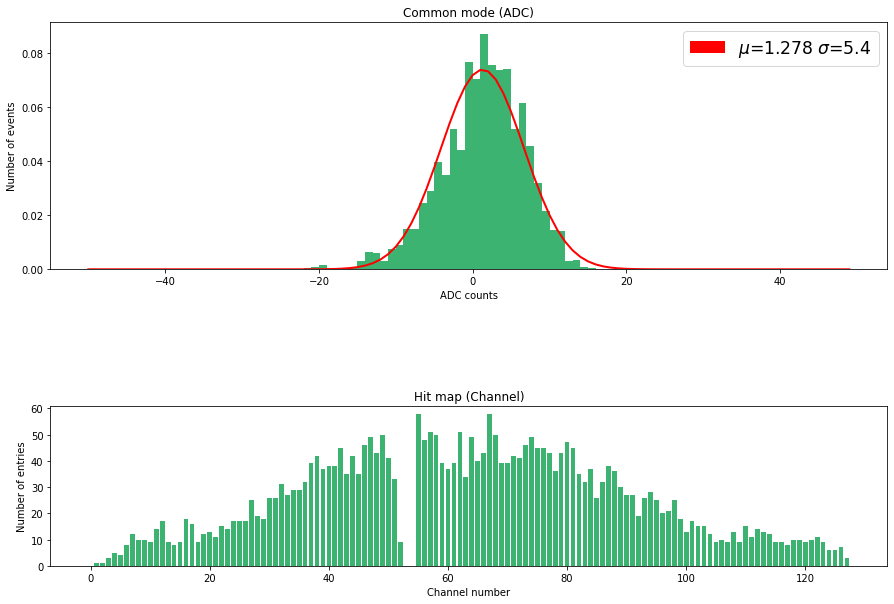

In [ ]:
#######################        
# PLot some quantities
########################

plt.figure(1,figsize=(15, 10))

# The common mode
X = r_[-50:50]
plt.subplot(2,1,1)
plt.title("Common mode (ADC)")
plt.ylabel('Number of events')
plt.xlabel('ADC counts')
n, bins, patches = plt.hist(C,X,color="mediumseagreen",density=True)
#   
mu, sigma = gaus.fit(C)
y = norm.pdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r-', linewidth=2)
p = plt.Rectangle((0, 0), 1, 1, fc="r")
plt.legend([p], [r'$\mu$=%.3f $\sigma$=%.1f' %( mu, sigma)], loc=1,fontsize="xx-large")

# The Hip map
X = r_[0:128:1]
plt.subplot(3,1,3)
plt.title("Hit map (Channel)")  
plt.ylabel('Number of entries')
plt.xlabel('Channel number')  
plt.bar(X,Hitm,color="mediumseagreen")
plt.show()

### Pedestals and Electronic Noise

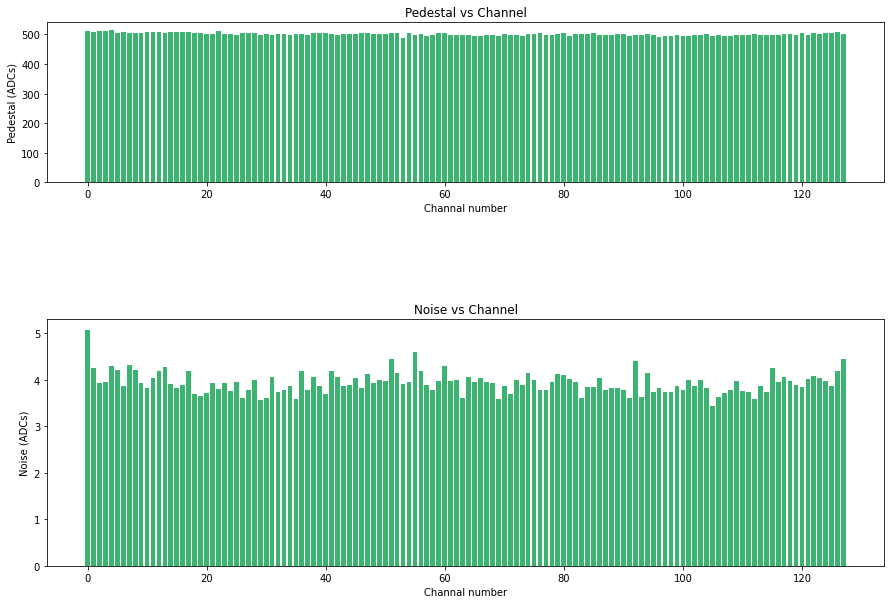

In [ ]:
plt.figure(2,figsize=(15, 10))

# Pedestals
X = r_[0:128:1]
plt.subplot(3,1,1)
plt.title("Pedestal vs Channel")   
plt.ylabel('Pedestal (ADCs)')
plt.xlabel('Channal number')  
plt.bar(X,pedestal,color="mediumseagreen")  


# Noise
X = r_[0:128:1]
plt.subplot(2,1,2)
plt.title("Noise vs Channel") 
plt.ylabel('Noise (ADCs)')
plt.xlabel('Channal number')    
plt.bar(X,noise,color="mediumseagreen") 
plt.show()

### Clusters and Timing

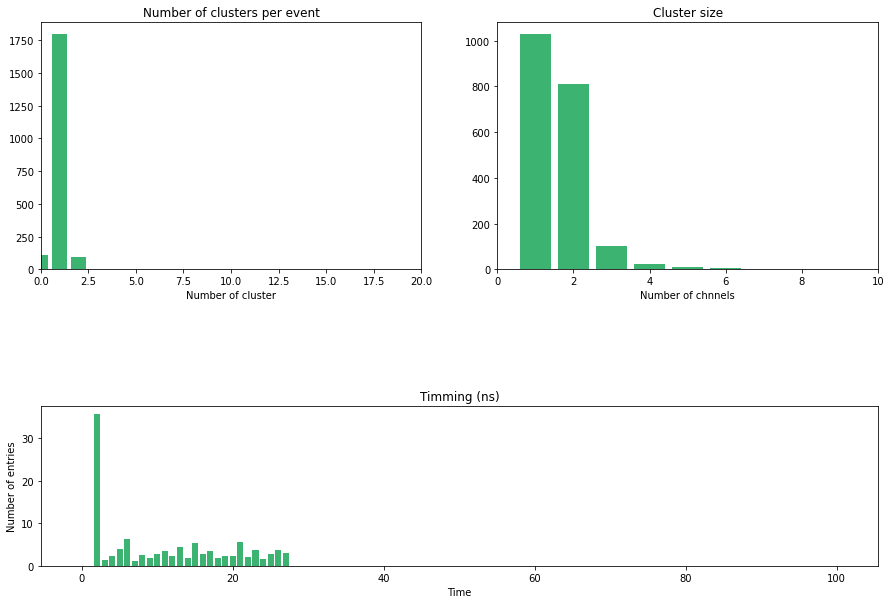

In [ ]:
plt.figure(3,figsize=(15, 10))

# Number of Clusters
X = r_[0:127:1]
plt.subplot(2,2,1)
plt.title("Number of clusters per event")  
plt.xlabel('Number of cluster')  
plt.xlim((0,20))
plt.bar(X,H[:127],color="mediumseagreen")
Tot=0
Ntot = 0
for i in range(0, 127):
    Tot = Tot + i*H[i]
    Ntot = Ntot + H[i]
if Tot>0:
    Tot =Tot/Ntot

#  Clusters size 
X = r_[0:127:1]
plt.subplot(2,2,2)
plt.title("Cluster size") 
plt.xlabel('Number of chnnels') 
plt.xlim((0,10)) 
plt.bar(X,CLsize[:127],color="mediumseagreen")
Tot=0
Ntot = 0
for i in range(0, 127):
    Tot = Tot + i*CLsize[i]
    Ntot = Ntot + CLsize[i]
if Tot>0:
    Tot =Tot/Ntot

# Timing
X = r_[0:101:1]
plt.subplot(3,1,3)
plt.title("Timming (ns)")  
plt.ylabel('Number of entries')
plt.xlabel('Time')

for i in range(0, 101):
    if TCls[i]>0:
        TMap[i]=TMap[i]/TCls[i] 
plt.bar(X,TMap,color="mediumseagreen")
plt.show()


### Raw Data

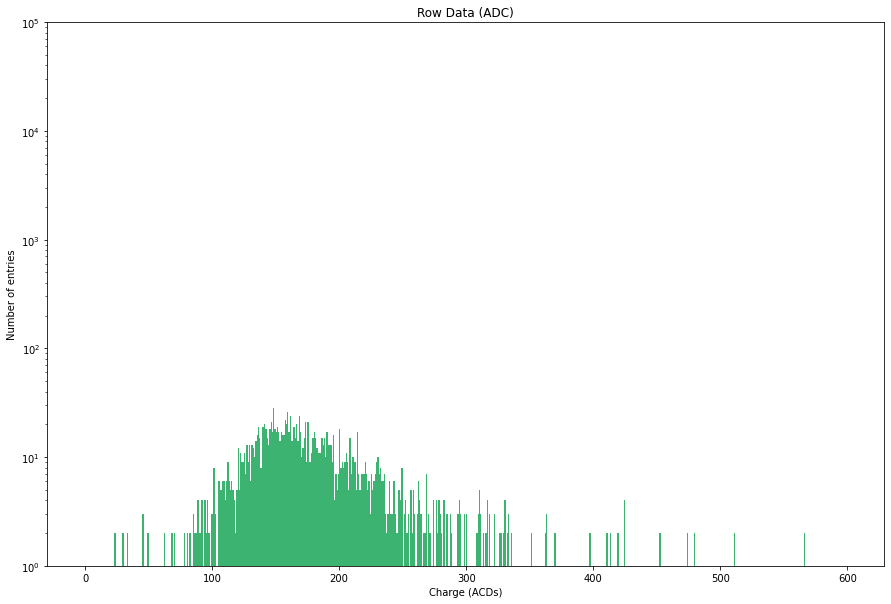

In [ ]:
plt.figure(4,figsize=(15, 10))

# Data histogram (the landau)

X = r_[0:600:1]
plt.title("Row Data (ADC)")
plt.ylabel('Number of entries')
plt.xlabel('Charge (ACDs)')
plt.ylim(1,100000)
n, bins, patches = plt.hist(G,X,color="mediumseagreen",log=True)
plt.show()

### ADC Counts

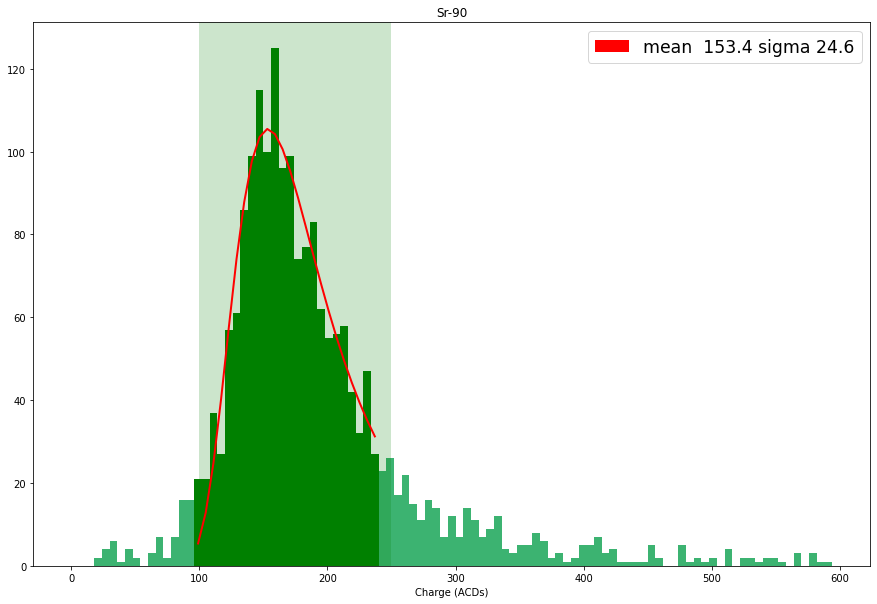

In [ ]:
plt.figure(5,figsize=(15, 10))

# Data histogram (the landau)
ADCbin=int(options_ADCbin)
ADCmax=int(options_ADCmax)
ADCmin=int(options_ADCmin)

X = r_[ADCmin:ADCmax:ADCbin]
plt.title(options_label) 
plt.xlabel('Charge (ACDs)')
plt.xlabel('Charge (ACDs)')

n, bins, patches = plt.hist(G,X,color="mediumseagreen")

fit_landau = options_landau

ibinmax= ADCbin*(int(options_fmax/ADCbin))
ibinmin= ADCbin*(int(options_fmin/ADCbin))
X = r_[ibinmin:ibinmax:ADCbin]

n, bins, patches = plt.hist(G,X,color = 'g')
indx = argmax(n, 0)
if fit_landau:
    errFunc = fitLandau
    dataFunc = fLandau
    param = [ 0.25*sum(n), bins[indx], 10. ]
else:
    errFunc = fitGauss
    dataFunc = fgauss
    param = [ sum(n), bins[indx], 10. ]


# Fit to the landau o gauss distribution 

step = 0.5*(bins[1]-bins[0])
X = bins[:-1] + step
fit_rc = optimize.leastsq(errFunc, param[:], args=(X, n))
fit_par = fit_rc[0]

# Draw the fitted curve on top of the histogram
y = dataFunc(fit_par, X)
l = plt.plot(X, y, 'r-', linewidth=2, label="hola")
plt.legend([p],[r'mean  %.1f sigma %.1f' % (fit_par[1], fit_par[2])], loc=1,fontsize="xx-large")
plt.axvspan(options_fmin, options_fmax, alpha=0.20,facecolor='g')
plt.show()

### Energy

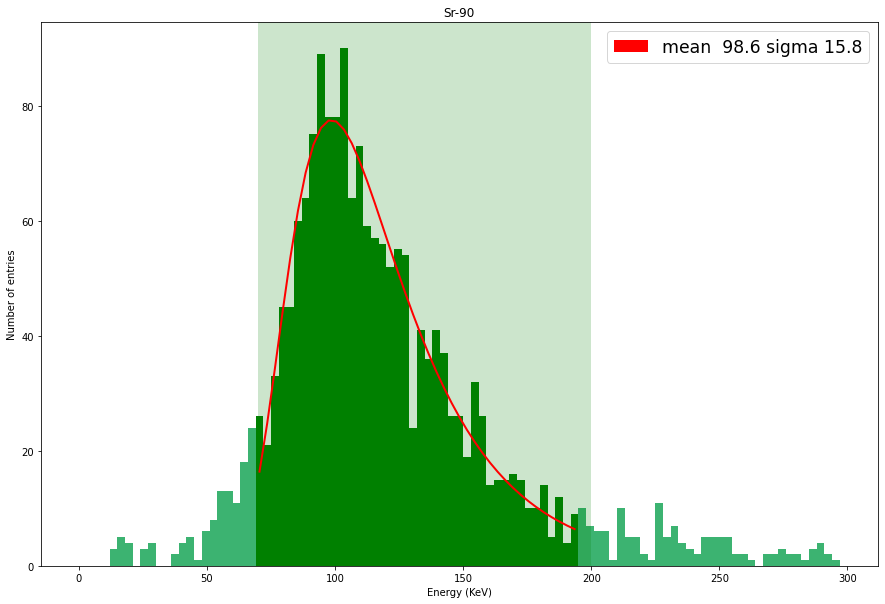

In [ ]:
plt.figure(6,figsize=(15, 10))

# Data histogram calibrated (the landau)
Eplotbin=int(options_Eplotbin)
Eplotmax=int(options_Eplotmax)
Eplotmin=int(options_Eplotmin)

X = r_[Eplotmin:Eplotmax:Eplotbin]

plt.title(options_label) 
plt.ylabel('Number of entries')
plt.xlabel('Energy (KeV)')

n, bins, patches = plt.hist(Gcal,X,color="mediumseagreen")

fit_landau = options_landau

Elecmin = options_Emin
Elecmax = options_Emax


ibinEmax= Eplotbin*(int(Elecmax/Eplotbin))
ibinEmin= Eplotbin*(int(Elecmin/Eplotbin))

X = r_[ibinEmin:ibinEmax:Eplotbin]

n, bins, patches = plt.hist(Gcal,X,color = 'g')
indx = argmax(n, 0)
if fit_landau:
    errFunc = fitLandau
    dataFunc = fLandau
    param = [ 0.25*sum(n), bins[indx], 10. ]
else:
    errFunc = fitGauss
    dataFunc = fgauss
    param = [ sum(n), bins[indx], 10. ]


# Fit to the landau distribution 

step = 0.5*(bins[1]-bins[0])
X = bins[:-1] + step
fit_rc = optimize.leastsq(errFunc, param[:], args=(X, n))
fit_par = fit_rc[0]

# Draw the fitted curve on top of the histogram
y = dataFunc(fit_par, X)
l = plt.plot(X, y, 'r-', linewidth=2, label="hola")
plt. legend([p],[r'mean  %.1f sigma %.1f' % (fit_par[1], fit_par[2])],loc=1,fontsize="xx-large")

plt.axvspan(Elecmin, Elecmax, alpha=0.20,facecolor='g')
plt.show()